In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [4]:
data = pd.read_csv('data/WindgeberHD.csv')  # Replace with your actual file path

# Remove non-numeric rows in 'windspeed'
data['windspeed'] = pd.to_numeric(data['windspeed'], errors='coerce')
data.dropna(subset=['windspeed'], inplace=True)
data.reset_index(drop=True, inplace=True)

# Normalize the data
wind_speed = data['windspeed'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
wind_speed_scaled = scaler.fit_transform(wind_speed)

# Define how many past observations to use for prediction
time_step = 60  # Using 10 previous data points to predict the next 10 seconds

# Create sequences and labels for LSTM
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(wind_speed_scaled, time_step)

# Reshape X to be [samples, time_steps, features] for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
model = Sequential()

# First LSTM layer
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Dense layer to output prediction
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=1024, validation_data=(X_test, y_test), verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform to get actual values
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

C:\Users\Piyush Rauniyar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 790s 729ms/step - loss: 0.0030 - val_loss: 6.3869e-04
Epoch 2/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 768s 713ms/step - loss: 8.3746e-04 - val_loss: 6.0168e-04
Epoch 3/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 801s 744ms/step - loss: 7.3236e-04 - val_loss: 5.9275e-04
Epoch 4/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 1278s 1s/step - loss: 7.0936e-04 - val_loss: 5.9551e-04
Epoch 5/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 1341s 1s/step - loss: 7.0439e-04 - val_loss: 5.9479e-04
Epoch 6/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 1360s 1s/step - loss: 7.0019e-04 - val_loss: 5.9135e-04
Epoch 7/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 1265s 1s/step - loss: 6.9796e-04 - val_loss: 5.9099e-04
Epoch 8/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 793s 736ms/step - loss: 6.9563e-04 - val_loss: 5.9342e-04
Epoch 9/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 816s 758ms/step - loss: 6.9698e-04 - val_loss: 5.9856e-04
Epoch 10/10
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 1203s 1s/step - loss: 6.9167e-04 - val_loss: 5.9294e-04
8613/8613 ━━━

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')


MSE: 0.23717676204975277
RMSE: 0.48700796918505634
MAE: 0.3568837955229359
R²: 0.9606395162881088


8613/8613 ━━━━━━━━━━━━━━━━━━━━ 423s 49ms/step
Mean Squared Error (MSE): 0.23717676204975277
Root Mean Squared Error (RMSE): 0.48700796918505634
Mean Absolute Error (MAE): 0.3568837955229359
R-Squared (R²): 0.9606395162881088
Mean Absolute Percentage Error (MAPE): inf%


C:\Users\Piyush Rauniyar\AppData\Local\Temp\ipykernel_13208\1997555266.py:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100


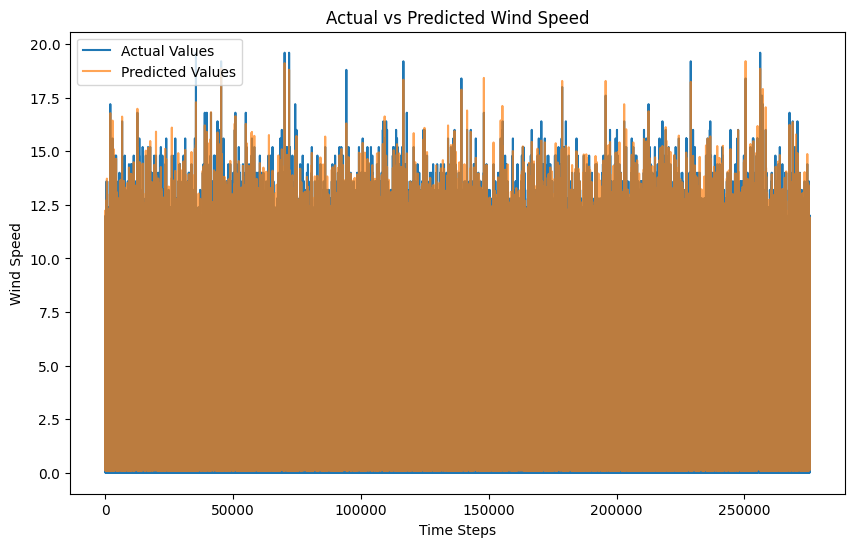

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and test data
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Evaluation Metrics

# 1. Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, y_pred_actual)
print(f'Mean Squared Error (MSE): {mse}')

# 2. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 3. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f'Mean Absolute Error (MAE): {mae}')

# 4. R-Squared (R²)
r2 = r2_score(y_test_actual, y_pred_actual)
print(f'R-Squared (R²): {r2}')

# 5. Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# Visualizing the Predictions vs Actual values

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(y_pred_actual, label='Predicted Values', alpha=0.7)
plt.title('Actual vs Predicted Wind Speed')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()


In [11]:
# Save the model
model.save('lstm_wind_speed_model.h5')

# To load the model again
from tensorflow.keras.models import load_model
loaded_model = load_model('lstm_wind_speed_model.h5')


In [12]:
import joblib
from sklearn.preprocessing import MinMaxScaler

# Assuming 'wind_speed' is your windspeed column as an array or DataFrame
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data
scaler.fit(wind_speed)

# Save the fitted scaler
joblib.dump(scaler, 'model/scaler.pkl')


['model/scaler.pkl']

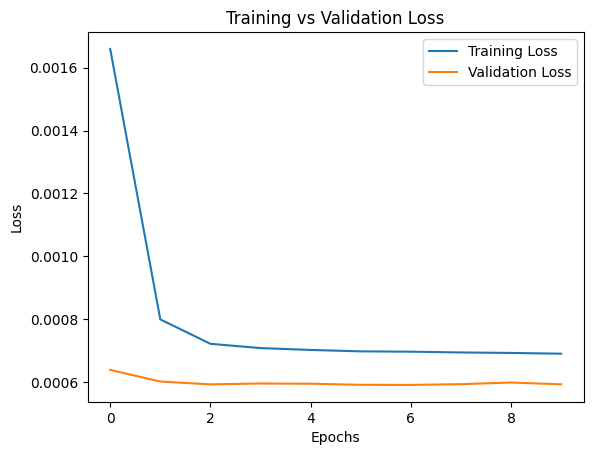

In [13]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# Evaluate on the training set
train_pred = model.predict(X_train)
train_pred_actual = scaler.inverse_transform(train_pred.reshape(-1, 1))
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Calculate metrics for training set
train_mse = mean_squared_error(train_actual, train_pred_actual)
train_r2 = r2_score(train_actual, train_pred_actual)

print(f"Training MSE: {train_mse}")
print(f"Training R²: {train_r2}")

# Evaluate on the validation/test set
test_pred = model.predict(X_test)
test_pred_actual = scaler.inverse_transform(test_pred.reshape(-1, 1))
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for test set
test_mse = mean_squared_error(test_actual, test_pred_actual)
test_r2 = r2_score(test_actual, test_pred_actual)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")


34449/34449 ━━━━━━━━━━━━━━━━━━━━ 760s 22ms/step
Training MSE: 0.23703763093011315
Training R²: 0.9605734558504571
8613/8613 ━━━━━━━━━━━━━━━━━━━━ 198s 23ms/step
Test MSE: 0.23717676204975277
Test R²: 0.9606395162881088


In [17]:
pip install scikeras[tensorflow]


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor  # Use SciKeras instead of TensorFlow wrappers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Function to build the Keras model
def build_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(64, return_sequences=False))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    return lstm_model

# Wrap the model using KerasRegressor from SciKeras
keras_regressor = KerasRegressor(model=build_lstm_model, epochs=10, batch_size=64, verbose=0)

# Perform cross-validation
kfold = KFold(n_splits=5, shuffle=True)
cv_scores = cross_val_score(keras_regressor, X, y, cv=kfold, scoring='neg_mean_squared_error')

# Output cross-validation results
print(f"Cross-Validation MSE: {np.mean(-cv_scores)}")


C:\Users\Piyush Rauniyar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Piyush Rauniyar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Piyush Rauniyar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
